In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def min_max_scale(df, global_min, global_max, exclude_cols=[]):
    scaled_df = df.copy()
    for col in df.columns:
        if col not in exclude_cols:
            scaled_df[col] = (df[col] - global_min) / (global_max - global_min)
    return scaled_df

In [4]:
def plot_image_from_dataframe(images_df, index, xlabel=None, ylabel=None, xticks=None, yticks=None):
    # Extract the image from the DataFrame
    image = images_df.loc[index, 'Image']

    # Plot the image
    plt.figure()
    plt.imshow(image, cmap='gray', aspect='auto')
    plt.colorbar()
    plt.title(f"Image for row {index}")

    # Set axis labels if provided
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    # plt.gca().invert_yaxis()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Set custom ticks if provided
    if xticks:
        plt.xticks(xticks)
    if yticks:
        plt.yticks(yticks)

    plt.show()

In [5]:
def create_3by5_list(dataframe):
    images = []
    for _, row in dataframe.iterrows():
        # 3x5 grid for each image representing the sensor layout
        image = np.zeros((3, 5))

        image[0, 0] = row['F7 (V)']
        image[0, 2] = row['F0 (V)']
        image[0, 4] = row['F1 (V)']
        image[1, 1] = row['F6 (V)']
        image[1, 3] = row['F2 (V)']
        image[2, 0] = row['F5 (V)']
        image[2, 2] = row['F4 (V)']
        image[2, 4] = row['F3 (V)']

        images.append(image)

    # Convert the list of images to a DataFrame
    images_df = pd.DataFrame({'Image': images})

    return images_df

In [6]:
def create_2by4_list(dataframe):
    images = []
    for _, row in dataframe.iterrows():
        # 2x4 grid for each image representing the sensor layout
        image = np.zeros((2, 4))

        image[0, 0] = row['F0 (V)']  # first sensor
        image[0, 1] = row['F1 (V)']
        image[0, 2] = row['F2 (V)']
        image[0, 3] = row['F3 (V)']
        image[1, 0] = row['F4 (V)']
        image[1, 1] = row['F5 (V)']
        image[1, 2] = row['F6 (V)']
        image[1, 3] = row['F7 (V)']

        images.append(image)

    # Convert the list of images to a DataFrame
    images_df = pd.DataFrame({'Image': images})

    return images_df

In [ ]:
def create_timeseries_list(dataframe, window_duration=0.5, num_points=200):
    num_sensors = 8
    images = []

    # dataframe['Time (s)'] = dataframe['Time (s)'].astype(float)

    # Sort dataframe by time
    # dataframe = dataframe.sort_values('Time (s)').reset_index(drop=True)

    # Calculate the total number of data points in the dataframe
    total_time_points = len(dataframe)
    # print(f"total time points: {total_time_points}")

    # Calculate the step size for overlapping windows
    step_size = num_points // 2

    # Loop through the dataframe with the given step size
    for start_idx in range(0, total_time_points - step_size + 1, step_size):
        end_idx = start_idx + num_points

        # Handle the case where the final window may be smaller than num_points
        if end_idx > total_time_points:
            window = dataframe.iloc[start_idx:]
            if len(window) < num_points:
                continue
        else:
            window = dataframe.iloc[start_idx:end_idx]

        # Initialize the image array with zeros
        image = np.zeros((num_sensors, num_points))

        # Print the range of indices for the current window
        # print(f"Window {len(images) + 1}: Start index = {start_idx}, End index = {end_idx}")

        # Populate the image array with sensor data
        for j in range(num_points):
            time_sec = j * window_duration  # Time in seconds
            time_index = int(time_sec / window_duration)  # Calculate column index

            if time_index < len(window):
                image[0, j] = window.iloc[time_index]['F0 (V)']
                image[1, j] = window.iloc[time_index]['F1 (V)']
                image[2, j] = window.iloc[time_index]['F2 (V)']
                image[3, j] = window.iloc[time_index]['F3 (V)']
                image[4, j] = window.iloc[time_index]['F4 (V)']
                image[5, j] = window.iloc[time_index]['F5 (V)']
                image[6, j] = window.iloc[time_index]['F6 (V)']
                image[7, j] = window.iloc[time_index]['F7 (V)']

        images.append(image)

    # Convert the list of images to a DataFrame
    images_df = pd.DataFrame({'Image': images})

    return images_df

# Usage example
# images_df = create_timeseries_list(dataframe)


In [8]:
GLOBAL_MIN = 0.45
GLOBAL_MAX = 1.5

def read_csv_files(exclude_cols, baseline):
  folder_path = '/content/drive/MyDrive/Research'

  # Use glob to find all CSV files in the specified folder
  file_paths = glob.glob(os.path.join(folder_path, '*.csv'))
  # print(file_paths)

  first_list = []
  second_list = []
  third_list = []

  label = ''

  for file_path in file_paths:
    if file_path.endswith('.csv'):
      df = pd.read_csv(file_path)
      if 'good' in file_path:
          df['Label'] = 'good'
          label = 'good'
      elif 'bad' in file_path:
        if 'left' in file_path:
          df['Label'] = 'bad_left'
          label = 'bad_left'
        elif 'right' in file_path:
          df['Label'] = 'bad_right'
          label = 'bad_right'
        elif 'front' in file_path:
          df['Label'] = 'bad_front'
          label = 'bad_front'
        elif 'back' in file_path:
          df['Label'] = 'bad_back'
          label = 'bad_back'
        else:
          df['Label'] = 'bad'
          label = 'bad'
          print("this is file_name:", file_path)
      else:
          df['Label'] = 'unknown'  # ?
          label = 'unknown'
    #df is the dataframe from the csv file

    # Find the index of the first row where any sensor value exceeds the baseline
    baseline_idx = df[(df[['F0 (V)', 'F1 (V)', 'F2 (V)', 'F3 (V)', 'F4 (V)', 'F5 (V)', 'F6 (V)', 'F7 (V)']] > baseline).any(axis=1)].index[0]

    # Slice the DataFrame from that index onward
    final_df = df.loc[baseline_idx:].reset_index(drop=True)

    # min max scaling
    final_df = min_max_scale(final_df, GLOBAL_MIN, GLOBAL_MAX, exclude_cols)
    # min_max_scale(final_df, GLOBAL_MIN, GLOBAL_MAX, exclude_cols)


    # concatenate for each dataframe
    first = create_3by5_list(final_df)
    first['Label'] = label
    first_list.append(first)

    second = create_2by4_list(final_df)
    second['Label'] = label
    second_list.append(second)

  #combine here
  first = pd.concat(first_list, ignore_index=True)
  second = pd.concat(second_list, ignore_index=True)

  # return three separate returns of the combinations
  return first, second

first, second = read_csv_files(exclude_cols = ['Time (s)', 'Label'], baseline = 0.61)

In [25]:
GLOBAL_MIN = 0.45
GLOBAL_MAX = 1.5

def read_csv_files(exclude_cols, baseline, folder_path = '/content/drive/MyDrive/Research'):

  # Use glob to find all CSV files in the specified folder
  file_paths = glob.glob(os.path.join(folder_path, '*.csv'))
  # print(file_paths)

  first_list = []
  second_list = []
  third_list = []

  label = ''

  for file_path in file_paths:
    if file_path.endswith('.csv'):
      df = pd.read_csv(file_path)
      if 'good' in file_path:
          df['Label'] = 'good'
          label = 'good'
      elif 'bad' in file_path:
        if 'left' in file_path:
          df['Label'] = 'bad_left'
          label = 'bad_left'
        elif 'right' in file_path:
          df['Label'] = 'bad_right'
          label = 'bad_right'
        elif 'front' in file_path:
          df['Label'] = 'bad_front'
          label = 'bad_front'
        elif 'back' in file_path:
          df['Label'] = 'bad_back'
          label = 'bad_back'
        else:
          df['Label'] = 'bad'
          label = 'bad'
          print("this is file_name:", file_path)
      else:
          df['Label'] = 'unknown'  # ?
          label = 'unknown'
    #df is the dataframe from the csv file

    # Find the index of the first row where any sensor value exceeds the baseline
    baseline_idx = df[(df[['F0 (V)', 'F1 (V)', 'F2 (V)', 'F3 (V)', 'F4 (V)', 'F5 (V)', 'F6 (V)', 'F7 (V)']] > baseline).any(axis=1)].index[0]

    # Slice the DataFrame from that index onward
    final_df = df.loc[baseline_idx:].reset_index(drop=True)

    # min max scaling
    final_df = min_max_scale(final_df, GLOBAL_MIN, GLOBAL_MAX, exclude_cols)
    # min_max_scale(final_df, GLOBAL_MIN, GLOBAL_MAX, exclude_cols)


    # concatenate for each dataframe
    first = create_3by5_list(final_df)
    first['Label'] = label
    first_list.append(first)

    second = create_2by4_list(final_df)
    second['Label'] = label
    second_list.append(second)

    # third = create_timeseries_list(final_df, window_duration=0.5, num_points=500)
    # third['Label'] = label
    # third_list.append(third)

  #combine here
  first = pd.concat(first_list, ignore_index=True)
  second = pd.concat(second_list, ignore_index=True)
  # third = pd.concat(third_list, ignore_index=True)

  # return three separate returns of the combinations
  return first, second

# first, second, third = read_csv_files(exclude_cols = ['Time (s)', 'Label'], baseline = 0.61)

<Axes: xlabel='Label'>

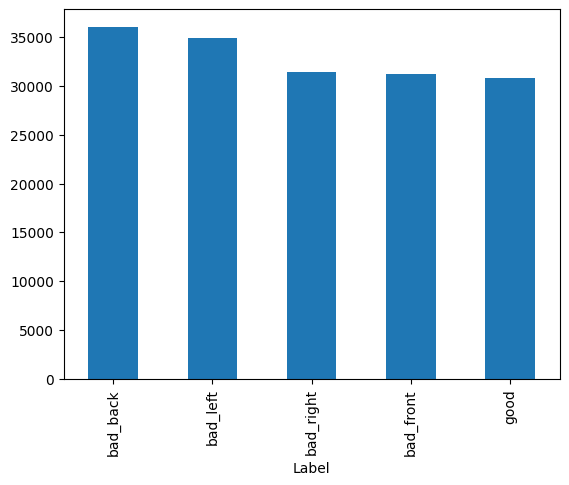

In [ ]:
# first - 3by5
# Get DF and plot Results
first.Label.value_counts().plot(kind='bar')

# second - 2by4

# third - time series

<Axes: xlabel='Label'>

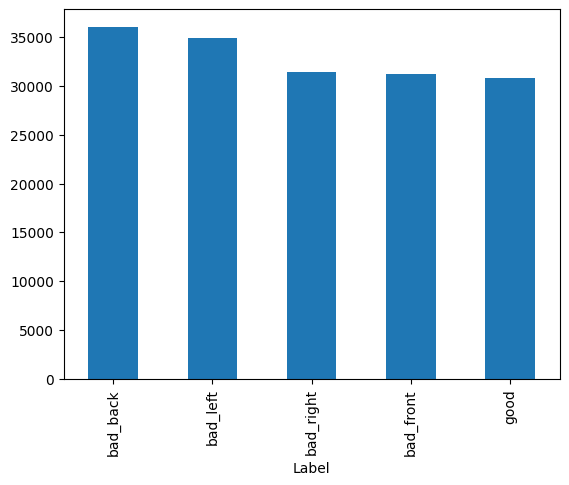

In [9]:
# 2 by 4 get DF and plot Results
second.Label.value_counts().plot(kind='bar')

In [41]:
import numpy as np

# Flatten all the arrays/lists in the 'Image' column (assuming the arrays/lists are in a column named 'Image')
flattened_values = np.hstack(two_by_four_df['Image'].values)

# Find the maximum value
max_value = np.max(flattened_values)

print("Maximum value in the entire DataFrame:", max_value)

Maximum value in the entire DataFrame: 0.6285714285714287


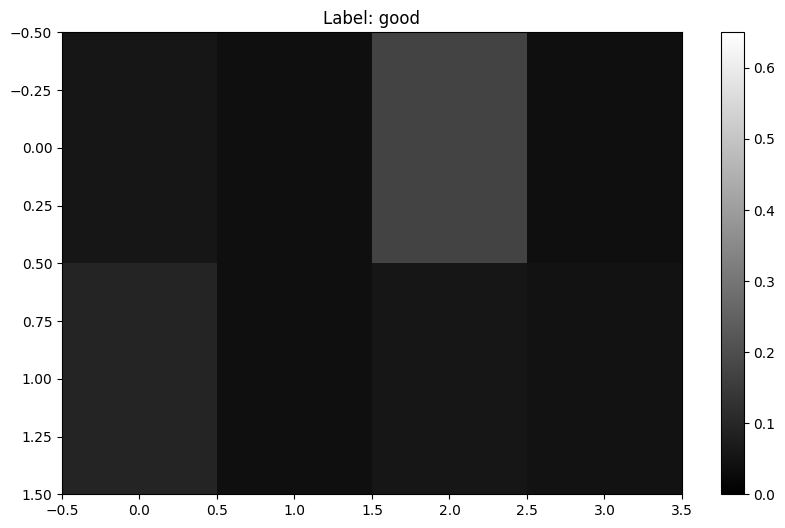

In [36]:
def display_image_by_label(df, label, vmin=None, vmax=None):
    # Filter the dataframe based on the label
    filtered_df = df[df['Label'] == label]

    if filtered_df.empty:
        print(f"No images found with label '{label}'.")
        return

    # Select a random image from the filtered dataframe
    random_image = filtered_df.sample(n=1)['Image'].values[0]

    # Display the image
    plt.figure(figsize=(10, 6))  # Adjust the size as necessary
    plt.imshow(random_image, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
    plt.title(f"Label: {label}")
    plt.colorbar()
    plt.show()

display_image_by_label(two_by_four_df, label='good', vmin=0, vmax=0.65)

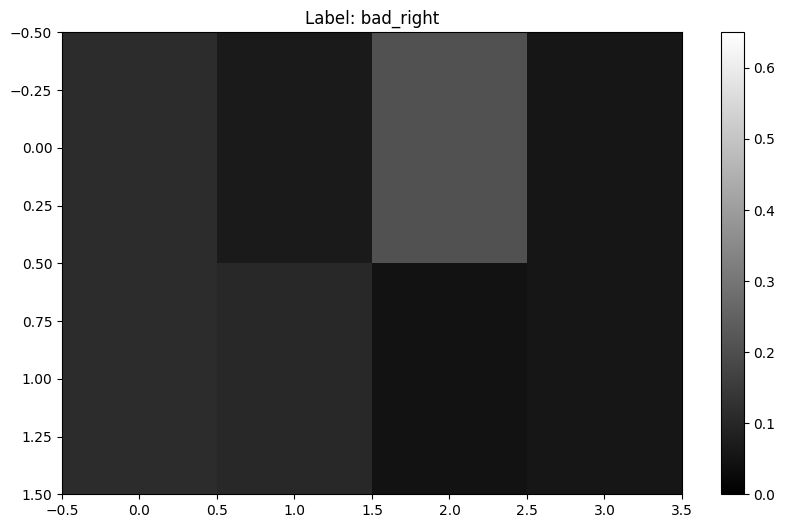

In [38]:
display_image_by_label(two_by_four_df, label='bad_right', vmin=0, vmax=0.65)

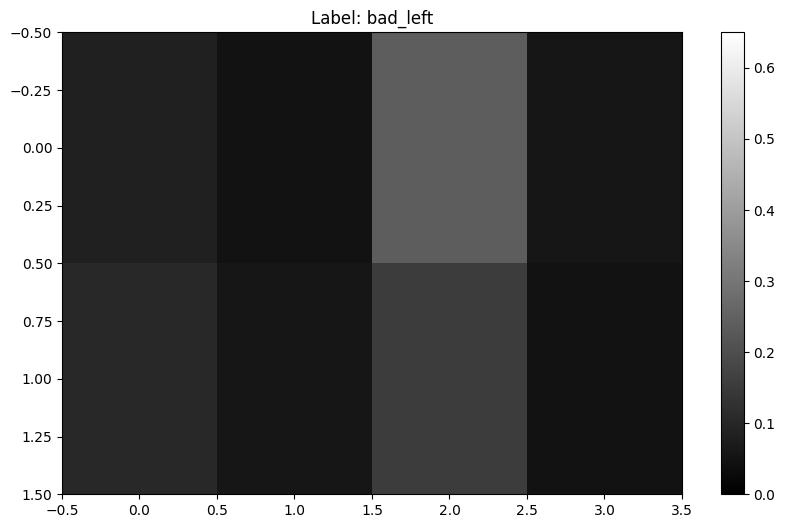

In [42]:
display_image_by_label(two_by_four_df, label='bad_left', vmin=0, vmax=0.65)

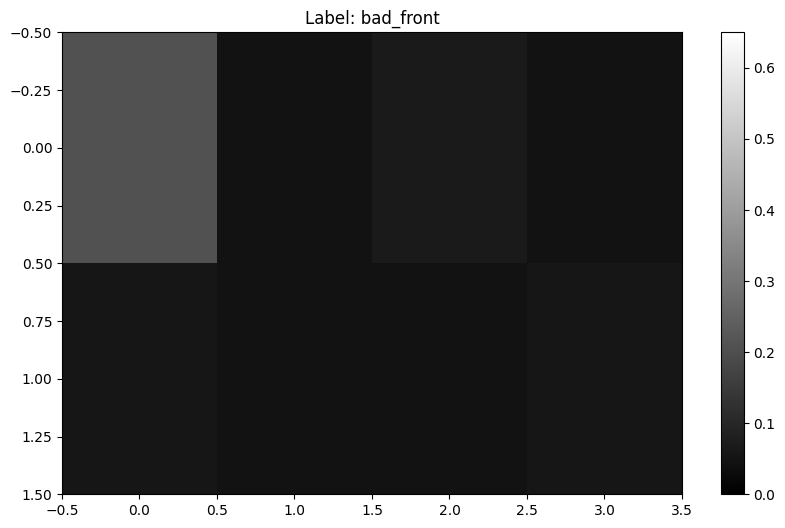

In [43]:
display_image_by_label(two_by_four_df, label='bad_front', vmin=0, vmax=0.65)

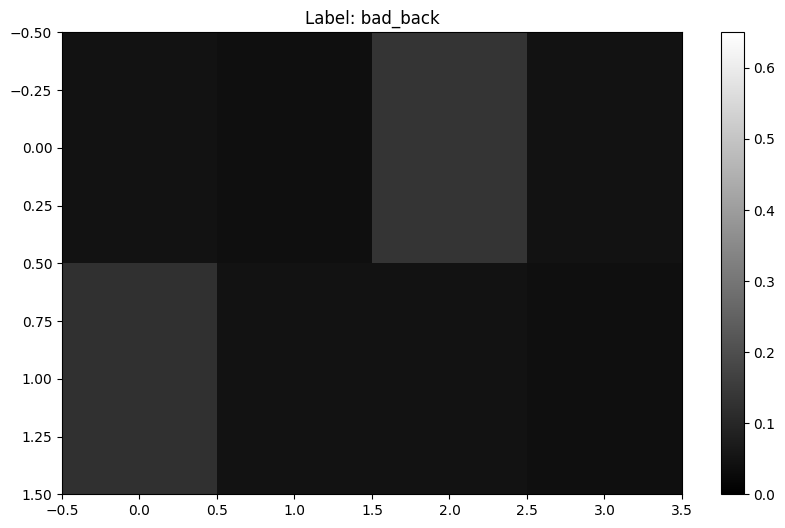

In [50]:
display_image_by_label(two_by_four_df, label='bad_back', vmin=0, vmax=0.65)

In [10]:
def save_df(df, filepath):
    directory = os.path.dirname(filepath)
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory '{directory}' does not exist.")
    try:
        df.to_pickle(filepath)
        print(f"Dataframe successfully saved to: {filepath}")
    except Exception as e:
        print(f"Failed to save dataframe to {filepath}: {e}")

def load_df(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File path '{filepath}' does not exist.")
    try:
        return pd.read_pickle(filepath)
    except Exception as e:
        print(f"Failed to load dataframe from {filepath}: {e}")
        return None

In [ ]:
# Save 3 by 5 df to pickle
filepath = '/content/drive/MyDrive/Research/3by5_df1.pkl'
save_df(first, filepath)

Dataframe successfully saved to: /content/drive/MyDrive/Research/3by5_df1.pkl


In [11]:
# Save 2 by 4 df to pickle
filepath = '/content/drive/MyDrive/Research/2by4_df1.pkl'
save_df(second,filepath)

Dataframe successfully saved to: /content/drive/MyDrive/Research/2by4_df1.pkl


<Axes: xlabel='Label'>

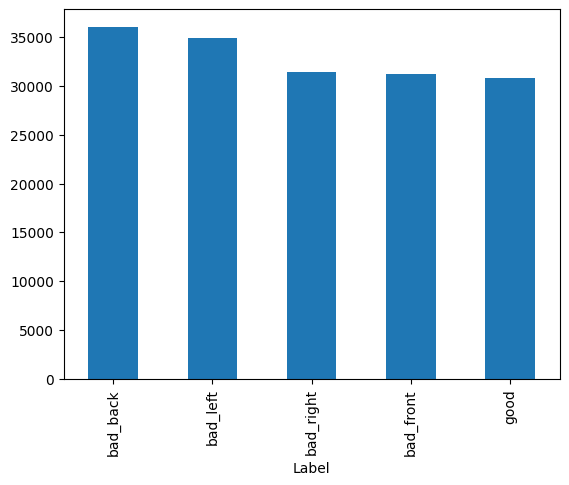

In [ ]:
# Load 3by5 df from pickle file
filepath = '/content/drive/MyDrive/Research/3by5_df1.pkl'
three_by_five_df = load_df(filepath)
three_by_five_df.Label.value_counts().plot(kind='bar')

<Axes: xlabel='Label'>

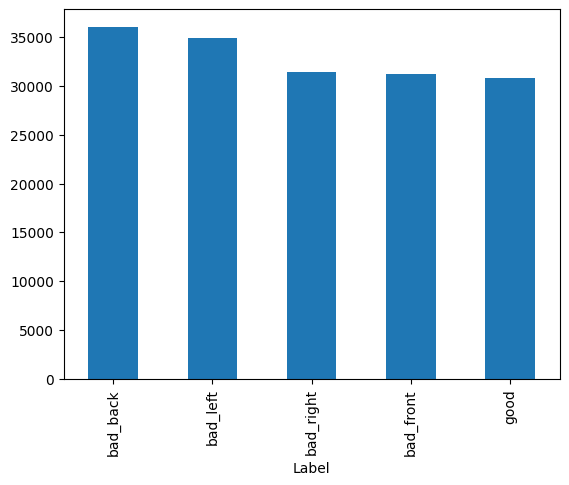

In [12]:
filepath = '/content/drive/MyDrive/Research/2by4_df1.pkl'
two_by_four_df = load_df(filepath)
two_by_four_df.Label.value_counts().plot(kind='bar')

In [ ]:
#creating the first train_test split 3 by 5

X = np.array(three_by_five_df['Image'].tolist())

# Encode labels to integers
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(three_by_five_df['Label'])

# Convert integer encoded labels to one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

# Ensure the shape is correct for CNN input
X = X.reshape(-1, 3, 5, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
#creating the second train_test split

X = np.array(second['Image'].tolist())

# Encode labels to integers
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(second['Label'])

# Convert integer encoded labels to one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

# Ensure the shape is correct for CNN input
X = X.reshape(-1, 2, 4, 1)

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=integer_encoded, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Grid search for seqential model for 2 by 4

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
X = np.array(three_by_five_df['Image'].tolist())
Y = three_by_five_df["Label"]

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(Y)
labels_categorical = to_categorical(labels_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, labels_categorical, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (119836, 3, 5)
y_train shape: (119836, 5)
X_test shape: (29960, 3, 5)
y_test shape: (29960, 5)


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
X = np.array(two_by_four_df['Image'].tolist())
Y = two_by_four_df["Label"]

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(Y)
labels_categorical = to_categorical(labels_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, labels_categorical, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (131539, 2, 4)
y_train shape: (131539, 5)
X_test shape: (32885, 2, 4)
y_test shape: (32885, 5)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(8,))

# Fully connected layers
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer for 5 classes
outputs = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,821 (11.02 KB)

 Trainable params: 2,821 (11.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 5: Evaluate the Model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=75, batch_size = 32, validation_split=0.2, callbacks=[callback])
if history is None:
    raise ValueError("The model training did not return a valid history object.")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5486 - loss: 1.1113 - val_accuracy: 0.6837 - val_loss: 0.6890
Epoch 2/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6773 - loss: 0.7020 - val_accuracy: 0.7157 - val_loss: 0.5918
Epoch 3/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7159 - loss: 0.6239 - val_accuracy: 0.7557 - val_loss: 0.5457
Epoch 4/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7401 - loss: 0.5890 - val_accuracy: 0.7803 - val_loss: 0.5218
Epoch 5/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7561 - loss: 0.5649 - val_accuracy: 0.7892 - val_loss: 0.5085
Epoch 6/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7637 - loss: 0.5520 - val_accuracy: 0.7992 - val_loss: 0.4893
Epoch 7/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7697 - loss: 0.5433 - val_accuracy: 0.8022 - val_loss: 0.4837
Epoch 8/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7734 - loss: 0.533

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(3, 5, 1))

# First conv layer with batch normalization
x = Conv2D(16, (2, 2), activation='relu', padding='same')(inputs)

# Second conv layer with batch normalization
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# Flatten the tensor to feed it to dense layer
x = Flatten()(x)

# Fully connected layer with batch normalization and dropout
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer for 5 classes
outputs = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 3, 5, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 3, 5, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 5, 32)            │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          30,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,733 (123.96 KB)

 Trainable params: 31,733 (123.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 5: Evaluate the Model
from tensorflow import keras

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=75, batch_size = 32, validation_split=0.2, callbacks=[callback])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6352 - loss: 0.8779 - val_accuracy: 0.7794 - val_loss: 0.5071
Epoch 2/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7827 - loss: 0.5126 - val_accuracy: 0.8047 - val_loss: 0.4592
Epoch 3/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8004 - loss: 0.4736 - val_accuracy: 0.8165 - val_loss: 0.4379
Epoch 4/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8115 - loss: 0.4552 - val_accuracy: 0.8136 - val_loss: 0.4345
Epoch 5/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8091 - loss: 0.4586 - val_accuracy: 0.8232 - val_loss: 0.4211
Epoch 6/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8156 - loss: 0.4449 - val_accuracy: 0.8233 - val_loss: 0.4229
Epoch 7/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8159 - loss: 0.4459 - val_accuracy: 0.8221 - val_loss: 0.4235
Epoch 8/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8171 - loss: 0.4430 

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(3, 5, 1))

# First conv layer with batch normalization
x = Conv2D(16, (2, 2), activation='relu', padding='same')(inputs)

# Second conv layer with batch normalization
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# Flatten the tensor to feed it to dense layer
x = Flatten()(x)

# Fully connected layer with batch normalization and dropout
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer for 5 classes
outputs = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 3, 5, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 5, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 5, 32)            │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │          30,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,989 (124.96 KB)

 Trainable params: 31,861 (124.46 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Step 5: Evaluate the Model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=75, batch_size = 32, validation_split=0.2, callbacks=[callback])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6908 - loss: 0.7366 - val_accuracy: 0.7750 - val_loss: 0.5223
Epoch 2/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7647 - loss: 0.5634 - val_accuracy: 0.7737 - val_loss: 0.5181
Epoch 3/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7827 - loss: 0.5336 - val_accuracy: 0.7621 - val_loss: 0.5846
Epoch 4/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7914 - loss: 0.5207 - val_accuracy: 0.8030 - val_loss: 0.4668
Epoch 5/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7946 - loss: 0.5129 - val_accuracy: 0.7917 - val_loss: 0.5086
Epoch 6/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7981 - loss: 0.5069 - val_accuracy: 0.8102 - val_loss: 0.4550
Epoch 7/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7997 - loss: 0.5002 - val_accuracy: 0.8148 - val_loss: 0.4608
Epoch 8/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8048 - loss: 0.4901

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(2, 4, 1))

# First conv layer with batch normalization
x = Conv2D(16, (2, 2), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

# Second conv layer with batch normalization
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# Flatten the tensor to feed it to dense layer
x = Flatten()(x)

# Fully connected layer with batch normalization and dropout
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer for 5 classes
outputs = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 2, 4, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 2, 4, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 4, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 2, 4, 32)            │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,845 (69.71 KB)

 Trainable params: 17,621 (68.83 KB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
# Step 5: Evaluate the Model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=75, batch_size = 32, validation_split=0.2, callbacks=[callback])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7177 - loss: 0.6778 - val_accuracy: 0.8001 - val_loss: 0.4893
Epoch 2/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7823 - loss: 0.5299 - val_accuracy: 0.8021 - val_loss: 0.4751
Epoch 3/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7910 - loss: 0.5090 - val_accuracy: 0.7523 - val_loss: 0.5570
Epoch 4/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8005 - loss: 0.4902 - val_accuracy: 0.7869 - val_loss: 0.5035
Epoch 5/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8052 - loss: 0.4784 - val_accuracy: 0.7642 - val_loss: 0.5300
Epoch 6/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8042 - loss: 0.4782 - val_accuracy: 0.8094 - val_loss: 0.4502
Epoch 7/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8061 - loss: 0.4713 - val_accuracy: 0.7921 - val_loss: 0.4877
Epoch 8/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8085 - loss: 0

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(2, 4, 1))

# First conv layer with batch normalization and dropout
x = Conv2D(16, (2, 2), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Second conv layer with batch normalization and dropout
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Flatten the tensor to feed it to dense layer
x = Flatten()(x)

# Fully connected layer with batch normalization and dropout
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer for 5 classes
outputs = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 2, 4, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 2, 4, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2, 4, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 2, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 2, 4, 32)            │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,845 (69.71 KB)

 Trainable params: 17,621 (68.83 KB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
# Step 5: Evaluate the Model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=75, batch_size = 32, validation_split=0.2, callbacks=[callback])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.6189 - loss: 0.9425 - val_accuracy: 0.7640 - val_loss: 0.5836
Epoch 2/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.7182 - loss: 0.6646 - val_accuracy: 0.7646 - val_loss: 0.5899
Epoch 3/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7315 - loss: 0.6349 - val_accuracy: 0.7849 - val_loss: 0.5403
Epoch 4/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.7382 - loss: 0.6174 - val_accuracy: 0.7961 - val_loss: 0.5139
Epoch 5/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7397 - loss: 0.6106 - val_accuracy: 0.8032 - val_loss: 0.5070
Epoch 6/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.7495 - loss: 0.5963 - val_accuracy: 0.8076 - val_loss: 0.4921
Epoch 7/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.7505 - loss: 0.5944 - val_accuracy: 0.8079 - val_loss: 0.5049
Epoch 8/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7544 - loss: 0

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(2, 4, 1))

# Single Convolutional Layer with 'same' padding
x = Conv2D(16, (2, 2), activation='relu', padding='same')(inputs)

# Global Average Pooling to flatten the feature map
x = GlobalAveragePooling2D()(x)

# Dense Layers
x = Dropout(0.3)(x)  # Dropout for regularization
x = Dense(64, activation='relu')(x)  # Adjust neurons if needed
x = Dropout(0.3)(x)  # Dropout for regularization
outputs = Dense(5, activation='softmax')(x)  # Adjust number of classes if needed

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(),  # Default learning rate of 0.001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 2, 4, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 2, 4, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,493 (5.83 KB)

 Trainable params: 1,493 (5.83 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 5: Evaluate the Model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=75, batch_size = 32, validation_split=0.2, callbacks=[callback])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.3319 - loss: 1.4935 - val_accuracy: 0.5674 - val_loss: 1.1624
Epoch 2/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5038 - loss: 1.2062 - val_accuracy: 0.5905 - val_loss: 1.0464
Epoch 3/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5391 - loss: 1.1230 - val_accuracy: 0.6142 - val_loss: 0.9777
Epoch 4/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5707 - loss: 1.0626 - val_accuracy: 0.6374 - val_loss: 0.9185
Epoch 5/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.5933 - loss: 1.0063 - val_accuracy: 0.6406 - val_loss: 0.8797
Epoch 6/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5998 - loss: 0.9751 - val_accuracy: 0.6382 - val_loss: 0.8612
Epoch 7/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6057 - loss: 0.9487 - val_accuracy: 0.6421 - val_loss: 0.8392
Epoch 8/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.6099 - loss: 0.9

KeyboardInterrupt: 

In [ ]:
# model using Functional API - 2 by  - using padding and smaller filter size, dropout layers, and global average pooling
# instead of flatten

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(2, 4, 1))

# Convolutional Layers
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)  # Small kernel
x = MaxPooling2D(pool_size=(1, 2))(x)  # Pooling with small stride

x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)  # Small kernel
x = MaxPooling2D(pool_size=(1, 2))(x)  # Pooling with small stride

# Use Global Average Pooling instead of Flatten
x = GlobalAveragePooling2D()(x)

# Dense Layers
x = Dropout(0.3)(x)  # Dropout for regularization
x = Dense(64, activation='relu')(x)  # Adjust neurons if needed
x = Dropout(0.3)(x)  # Dropout for regularization
outputs = Dense(5, activation='softmax')(x)  # Adjust number of classes if needed

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(),  # Default learning rate of 0.001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 2, 4, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 2, 4, 16)            │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 2, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 2, 2, 32)            │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,677 (18.27 KB)

 Trainable params: 4,677 (18.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 5: Evaluate the Model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=75, batch_size = 32, validation_split=0.2, callbacks=[callback])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.5447 - loss: 1.0736 - val_accuracy: 0.6937 - val_loss: 0.6292
Epoch 2/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7033 - loss: 0.6444 - val_accuracy: 0.7617 - val_loss: 0.5522
Epoch 3/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7508 - loss: 0.5751 - val_accuracy: 0.7811 - val_loss: 0.5066
Epoch 4/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7699 - loss: 0.5420 - val_accuracy: 0.8007 - val_loss: 0.4817
Epoch 5/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7821 - loss: 0.5203 - val_accuracy: 0.7969 - val_loss: 0.4813
Epoch 6/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7848 - loss: 0.5147 - val_accuracy: 0.8057 - val_loss: 0.4688
Epoch 7/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7897 - loss: 0.5047 - val_accuracy: 0.8001 - val_loss: 0.4728
Epoch 8/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7913 - loss: 0.5

In [ ]:
# model using Functional API - 2 by  - using padding abd smaller filter size, dropout layers,
# and no fully connected/dense layer

inputs = Input(shape=(2, 4, 1))
x = Conv2D(16, (2, 2), activation='relu', padding='same')(inputs)  # First conv layer
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)  # Second conv layer
x = Flatten()(x)  # Flatten the tensor
x = Dropout(0.3)(x)  # Dropout layer
outputs = Dense(5, activation='softmax')(x)  # Output layer for 5 classes

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and categorical cross-entropy loss
# no learning rate
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 2, 4, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 2, 4, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 2, 4, 32)            │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,909 (7.46 KB)

 Trainable params: 1,909 (7.46 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 5: Evaluate the Model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=75, batch_size = 32, validation_split=0.2, callbacks=[callback])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5492 - loss: 1.0867 - val_accuracy: 0.6921 - val_loss: 0.6504
Epoch 2/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6940 - loss: 0.6841 - val_accuracy: 0.7243 - val_loss: 0.6148
Epoch 3/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7075 - loss: 0.6611 - val_accuracy: 0.7382 - val_loss: 0.6007
Epoch 4/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7180 - loss: 0.6432 - val_accuracy: 0.7376 - val_loss: 0.5955
Epoch 5/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7222 - loss: 0.6337 - val_accuracy: 0.7307 - val_loss: 0.5955
Epoch 6/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7228 - loss: 0.6242 - val_accuracy: 0.7446 - val_loss: 0.5837
Epoch 7/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7230 - loss: 0.6234 - val_accuracy: 0.7375 - val_loss: 0.5828
Epoch 8/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7286 - loss: 0.612

In [ ]:
# model using Functional API - 2 by  - using padding abd smaller filter size, dropout layers
from tensorflow.keras.layers import Dense, Dropout, Input

inputs = Input(shape=(2, 4, 1))
x = Conv2D(16, (2, 2), activation='relu', padding='same')(inputs)  # First conv layer
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)  # Second conv layer
x = Flatten()(x)  # Flatten the tensor to feed it to dense layer
x = Dropout(0.3)(x)  # Dropout layer with a rate of 0.3
x = Dense(64, activation='relu')(x)  # Fully connected layer
x = Dropout(0.3)(x)  # Dropout layer with a rate of 0.3
outputs = Dense(5, activation='softmax')(x)  # Output layer for 6 classes

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and categorical cross-entropy loss
# no learning rate
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


# try 1 layer of max pooling with 3x5
# padding
# flatten and dropout
# create callback (and add when creating model)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 2, 4, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 2, 4, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 2, 4, 32)            │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,397 (67.96 KB)

 Trainable params: 17,397 (67.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 5: Evaluate the Model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=75, batch_size = 32, validation_split=0.2, callbacks=[callback])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.5913 - loss: 0.9633 - val_accuracy: 0.7566 - val_loss: 0.5550
Epoch 2/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7391 - loss: 0.5940 - val_accuracy: 0.7981 - val_loss: 0.4976
Epoch 3/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7665 - loss: 0.5461 - val_accuracy: 0.8120 - val_loss: 0.4649
Epoch 4/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7769 - loss: 0.5245 - val_accuracy: 0.8160 - val_loss: 0.4574
Epoch 5/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7825 - loss: 0.5155 - val_accuracy: 0.8157 - val_loss: 0.4533
Epoch 6/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.7889 - loss: 0.5058 - val_accuracy: 0.8218 - val_loss: 0.4379
Epoch 7/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.7928 - loss: 0.4979 - val_accuracy: 0.8230 - val_loss: 0.4417
Epoch 8/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7947 - loss: 0.

KeyboardInterrupt: 

# HIGHEST

In [30]:
# model using Functional API - 3 by 5 - using padding and smaller filter size
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam, SGD

batch_size = 32

inputs = Input(shape=(2, 4, 1))
x = Conv2D(16, (2, 2), activation='relu', padding='same')(inputs)  # First conv layer
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)  # Second conv layer
x = Flatten()(x)  # Flatten the tensor to feed it to dense layer
x = Dense(64, activation='relu')(x)  # Fully connected layer
outputs = Dense(5, activation='softmax')(x)  # Output layer for 6 classes

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and categorical cross-entropy loss
# no learning rate

initial_lr = 0.001
decay_rate = 0.96
decay_steps = len(X_train) // batch_size  # decay every epoch

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum = .9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2, 4, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 2, 4, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 4, 32)            │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,397 (67.96 KB)

 Trainable params: 17,397 (67.96 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# model using Functional API - 2 by  - using padding abd smaller filter size
#HIGHEST
inputs = Input(shape=(2, 4, 1))
x = Conv2D(16, (2, 2), activation='relu', padding='same')(inputs)  # First conv layer
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)  # Second conv layer
x = Flatten()(x)  # Flatten the tensor to feed it to dense layer
x = Dense(64, activation='relu')(x)  # Fully connected layer
outputs = Dense(5, activation='softmax')(x)  # Output layer for 6 classes

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and categorical cross-entropy loss
# no learning rate
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


# try 1 layer of max pooling with 3x5
# padding
# flatten and dropout
# create callback (and add when creating model)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 2, 4, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 2, 4, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 2, 4, 32)            │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,397 (67.96 KB)

 Trainable params: 17,397 (67.96 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Step 5: Evaluate the Model

from tensorflow import keras

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=200, batch_size = 32, validation_split=0.2, callbacks=[callback])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.3634 - loss: 1.5543 - val_accuracy: 0.5946 - val_loss: 1.1737
Epoch 2/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6139 - loss: 1.0366 - val_accuracy: 0.6458 - val_loss: 0.8440
Epoch 3/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6656 - loss: 0.8087 - val_accuracy: 0.6866 - val_loss: 0.7402
Epoch 4/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6918 - loss: 0.7256 - val_accuracy: 0.7039 - val_loss: 0.7010
Epoch 5/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7059 - loss: 0.6768 - val_accuracy: 0.7177 - val_loss: 0.6666
Epoch 6/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7200 - loss: 0.6448 - val_accuracy: 0.7281 - val_loss: 0.6309
Epoch 7/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7284 - loss: 0.6244 - val_accuracy: 0.7377 - val_loss: 0.6183
Epoch 8/200
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7381 - loss

683/683 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


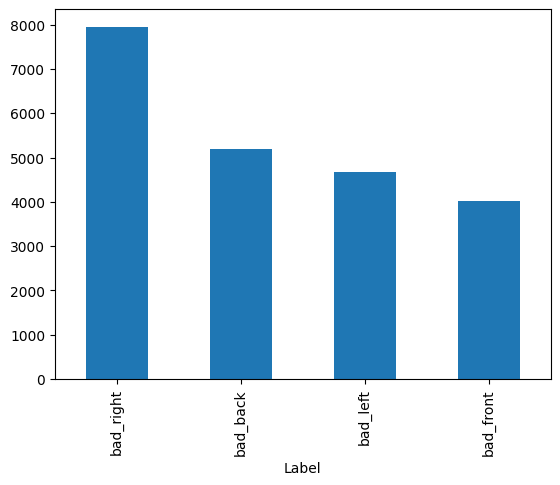

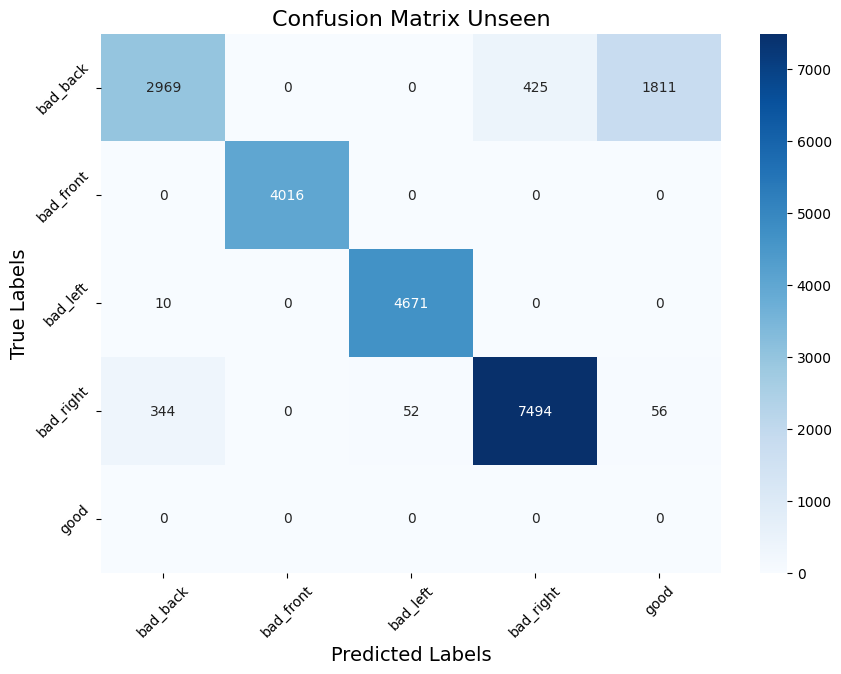

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.89      0.57      0.70      5205
   bad_front       1.00      1.00      1.00      4016
    bad_left       0.99      1.00      0.99      4681
   bad_right       0.95      0.94      0.94      7946
        good       0.00      0.00      0.00         0

    accuracy                           0.88     21848
   macro avg       0.77      0.70      0.73     21848
weighted avg       0.95      0.88      0.91     21848



In [34]:
test_unseen_data('/content/drive/MyDrive/Research/Unseen Data Medium Circle', model, label_encoder)

1319/1319 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


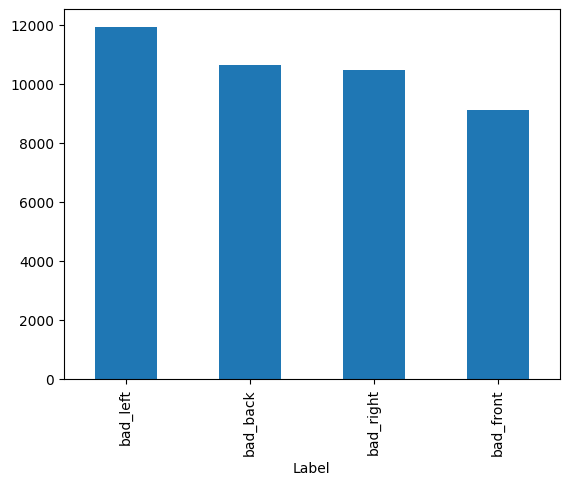

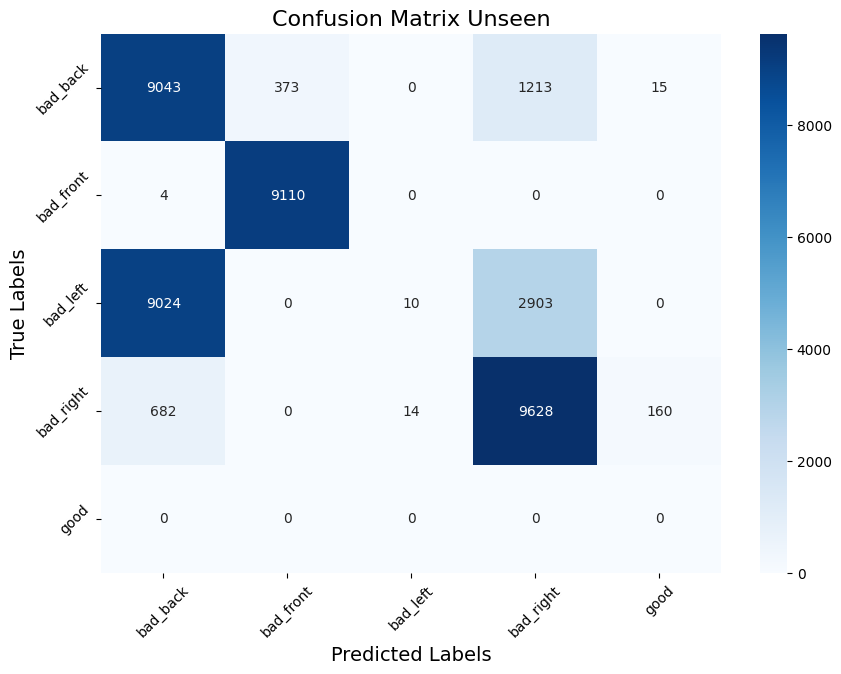

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.48      0.85      0.62     10644
   bad_front       0.96      1.00      0.98      9114
    bad_left       0.42      0.00      0.00     11937
   bad_right       0.70      0.92      0.79     10484
        good       0.00      0.00      0.00         0

    accuracy                           0.66     42179
   macro avg       0.51      0.55      0.48     42179
weighted avg       0.62      0.66      0.56     42179



In [35]:
test_unseen_data('/content/drive/MyDrive/Research/Unseen Data Large Ellipse', model, label_encoder)

In [17]:
# Step 5: Evaluate the Model

from tensorflow import keras

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=75, batch_size = 32, validation_split=0.2, callbacks=[callback])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6290 - loss: 0.9010 - val_accuracy: 0.7757 - val_loss: 0.5501
Epoch 2/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7885 - loss: 0.5271 - val_accuracy: 0.8110 - val_loss: 0.4700
Epoch 3/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8100 - loss: 0.4716 - val_accuracy: 0.8166 - val_loss: 0.4545
Epoch 4/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8166 - loss: 0.4537 - val_accuracy: 0.8140 - val_loss: 0.4603
Epoch 5/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8206 - loss: 0.4486 - val_accuracy: 0.8266 - val_loss: 0.4357
Epoch 6/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8222 - loss: 0.4423 - val_accuracy: 0.8259 - val_loss: 0.4336
Epoch 7/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8225 - loss: 0.4392 - val_accuracy: 0.8287 - val_loss: 0.4283
Epoch 8/75
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8245 - loss: 0.43

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

def test_data(model, label_encoder):
      # Plotting the distribution of labels in the unseen data
      two_by_four_df.Label.value_counts().plot(kind='bar')

      # Prepare the unseen data
      X_unseen = np.array(two_by_four_df['Image'].tolist())
      Y_unseen = two_by_four_df["Label"]

      # Encode and categorize the labels
      labels_encoded = label_encoder.transform(Y_unseen)
      labels_categorical = to_categorical(labels_encoded)

      # Predict using the model
      y_pred_prob = model.predict(X_unseen.reshape(-1, 2, 4, 1))
      y_pred = np.argmax(y_pred_prob, axis=1)
      y_true = np.argmax(labels_categorical, axis=1)


      labels_guessed = list(set(np.concatenate((y_pred, y_true))))

      # Confusion Matrix
      confusion = confusion_matrix(y_true, y_pred)

      # Plot Confusion Matrix
      plt.figure(figsize=(10, 7))
      sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
      plt.title("Confusion Matrix", fontsize=16)
      plt.xlabel('Predicted Labels', fontsize=14)
      plt.ylabel('True Labels', fontsize=14)
      plt.xticks(rotation=45)
      plt.yticks(rotation=45)
      plt.show()

      # Classification Report
      print(labels_guessed)
      report = classification_report(y_true, y_pred, labels=labels_guessed, target_names=label_encoder.classes_, zero_division=0)
      print("Classification Report:")
      print(report)

5139/5139 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


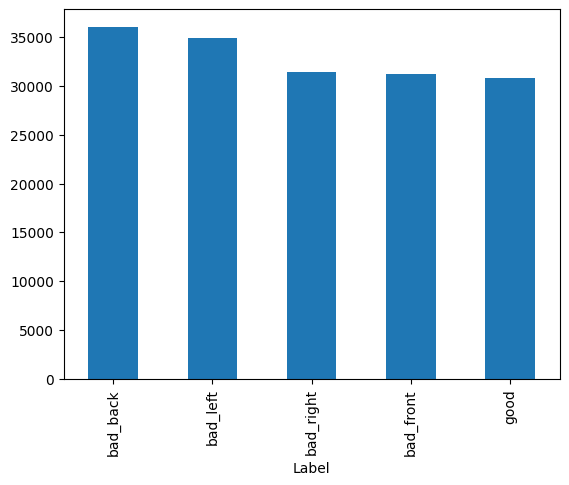

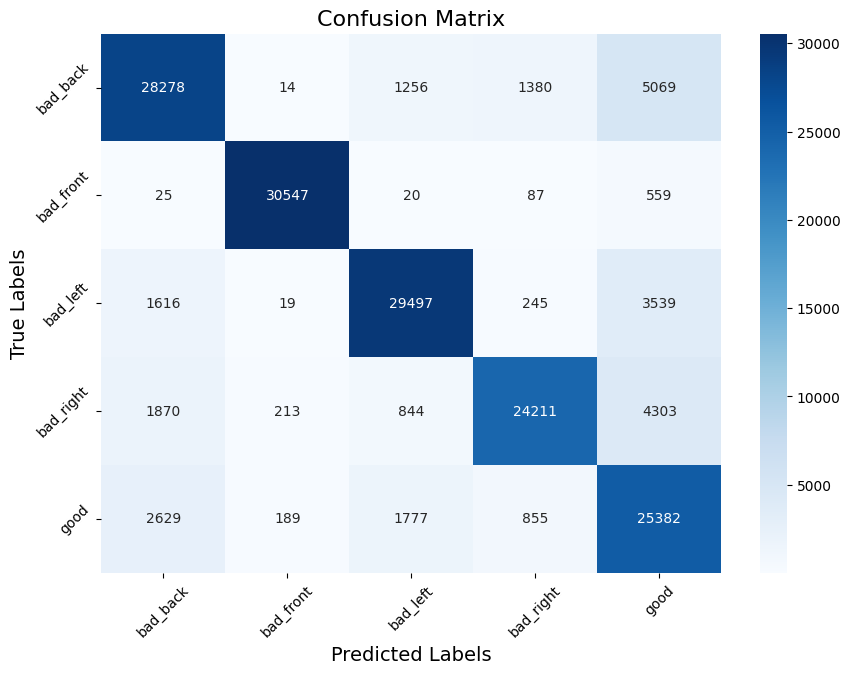

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.82      0.79      0.80     35997
   bad_front       0.99      0.98      0.98     31238
    bad_left       0.88      0.84      0.86     34916
   bad_right       0.90      0.77      0.83     31441
        good       0.65      0.82      0.73     30832

    accuracy                           0.84    164424
   macro avg       0.85      0.84      0.84    164424
weighted avg       0.85      0.84      0.84    164424



In [21]:
test_data(model, label_encoder)

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

def test_unseen_data(filepath, model, label_encoder):

      # Read the CSV files while excluding specific columns
      first, second = read_csv_files(exclude_cols=['Time (s)', 'Label'], baseline=0.6, folder_path=filepath)

      if second.empty:
          print("No data found in the provided path.")
          return

      # Plotting the distribution of labels in the unseen data
      second.Label.value_counts().plot(kind='bar')

      # Prepare the unseen data
      X_unseen = np.array(second['Image'].tolist())
      Y_unseen = second["Label"]

      # Encode and categorize the labels
      labels_encoded = label_encoder.transform(Y_unseen)
      labels_categorical = to_categorical(labels_encoded)

      # Predict using the model
      y_pred_prob = model.predict(X_unseen.reshape(-1, 2, 4, 1))
      y_pred = np.argmax(y_pred_prob, axis=1)
      y_true = np.argmax(labels_categorical, axis=1)


      labels_guessed = list(set(np.concatenate((y_pred, y_true))))

      # Confusion Matrix
      confusion = confusion_matrix(y_true, y_pred)

      # Plot Confusion Matrix
      plt.figure(figsize=(10, 7))
      sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
      plt.title("Confusion Matrix Unseen", fontsize=16)
      plt.xlabel('Predicted Labels', fontsize=14)
      plt.ylabel('True Labels', fontsize=14)
      plt.xticks(rotation=45)
      plt.yticks(rotation=45)
      plt.show()

      # Classification Report
      print(labels_guessed)
      report = classification_report(y_true, y_pred, labels=labels_guessed, target_names=label_encoder.classes_, zero_division=0)
      print("Classification Report:")
      print(report)

683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


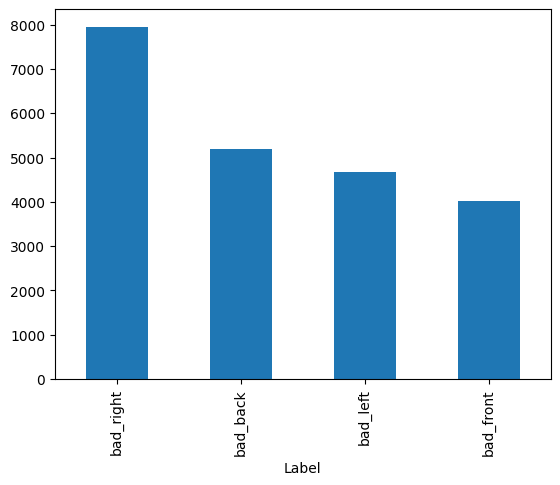

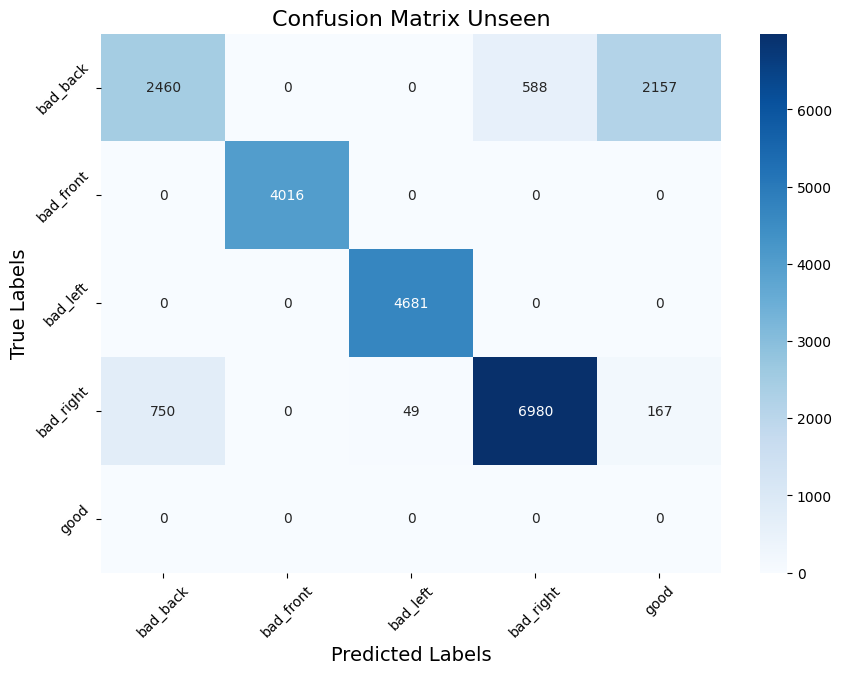

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.77      0.47      0.58      5205
   bad_front       1.00      1.00      1.00      4016
    bad_left       0.99      1.00      0.99      4681
   bad_right       0.92      0.88      0.90      7946
        good       0.00      0.00      0.00         0

    accuracy                           0.83     21848
   macro avg       0.74      0.67      0.70     21848
weighted avg       0.91      0.83      0.86     21848



In [27]:
test_unseen_data('/content/drive/MyDrive/Research/Unseen Data Medium Circle', model, label_encoder)

1319/1319 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


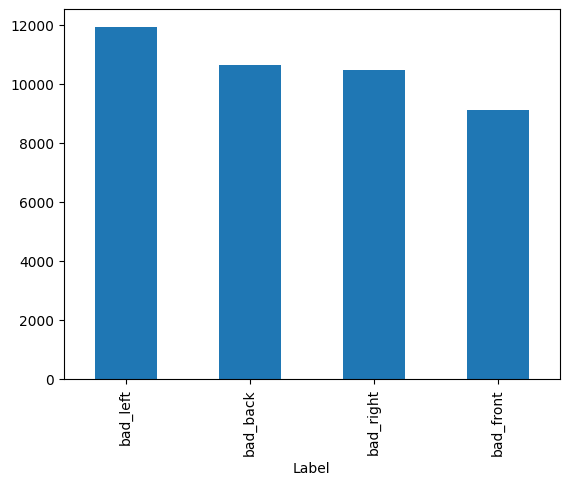

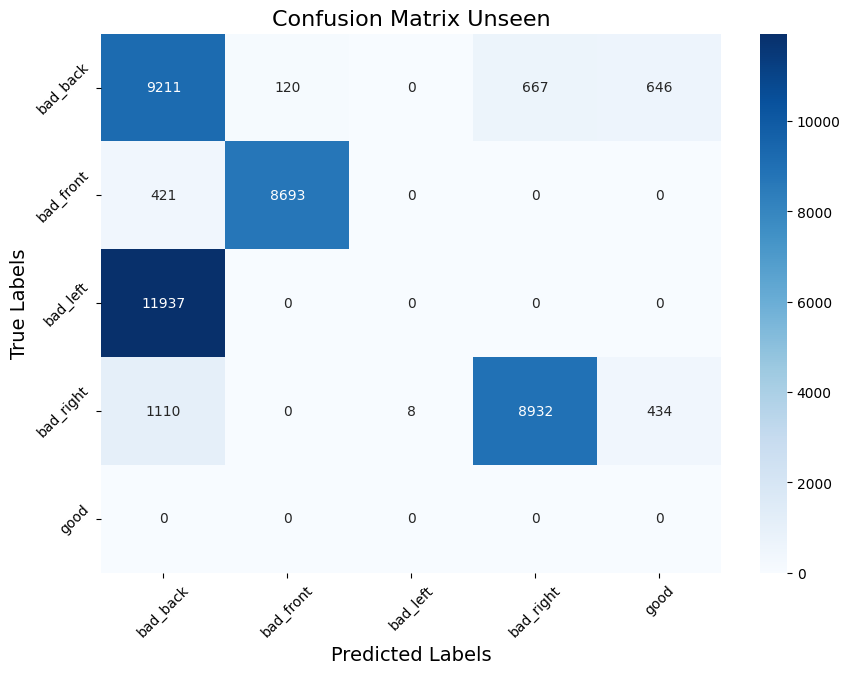

[0, 1, 2, 3, 4]
Classification Report:
              precision    recall  f1-score   support

    bad_back       0.41      0.87      0.55     10644
   bad_front       0.99      0.95      0.97      9114
    bad_left       0.00      0.00      0.00     11937
   bad_right       0.93      0.85      0.89     10484
        good       0.00      0.00      0.00         0

    accuracy                           0.64     42179
   macro avg       0.46      0.53      0.48     42179
weighted avg       0.55      0.64      0.57     42179



In [28]:
test_unseen_data('/content/drive/MyDrive/Research/Unseen Data Large Ellipse', model, label_encoder)

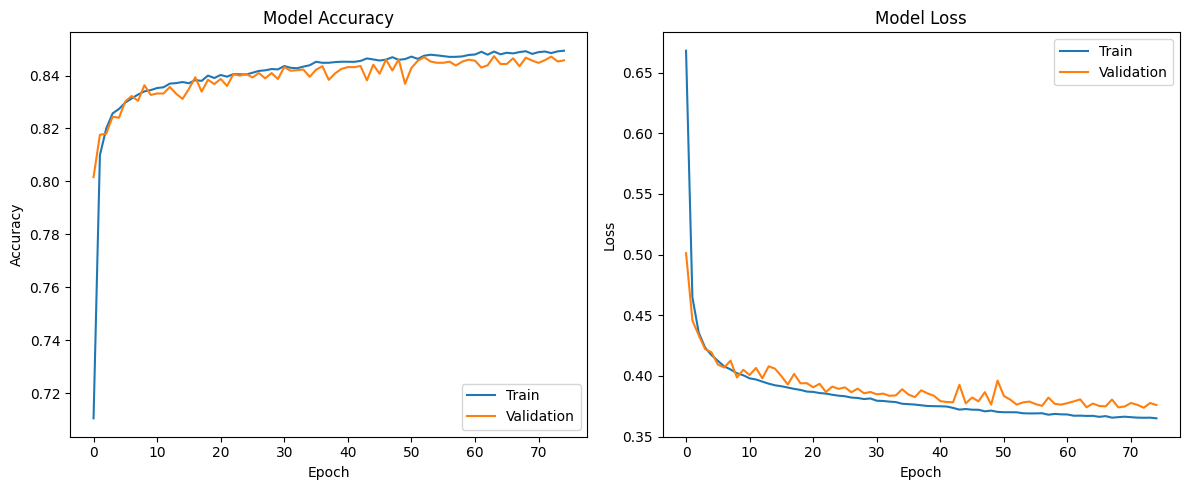

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [ ]:
# model using Functional API - 2 by 4

inputs = Input(shape=(2, 4, 1))
x = Conv2D(32, (2, 2), activation='relu')(inputs)  # First conv layer
x = Conv2D(64, (1, 1), activation='relu')(x)  # Second conv layer
x = Flatten()(x)  # Flatten the tensor to feed it to dense layer
x = Dense(128, activation='relu')(x)  # Fully connected layer
outputs = Dense(5, activation='softmax')(x)  # Output layer for 6 classes

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and categorical cross-entropy loss
# no learning rate
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
# history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Loss: {loss}, Accuracy: {accuracy}')
# print(model.summary())

# try 1 layer of max pooling with 3x5
# padding
# flatten and dropout
# create callback (and add when creating model)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 2, 4, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 1, 3, 32)            │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 1, 3, 64)            │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,621 (107.89 KB)

 Trainable params: 27,621 (107.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow import keras

# Step 5: Evaluate the Model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=75, batch_size = 32, validation_split=0.2, callbacks=[callback])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

Epoch 1/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6237 - loss: 0.8909 - val_accuracy: 0.7009 - val_loss: 0.6273
Epoch 2/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7392 - loss: 0.5866 - val_accuracy: 0.7881 - val_loss: 0.5151
Epoch 3/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7917 - loss: 0.5006 - val_accuracy: 0.8052 - val_loss: 0.4759
Epoch 4/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8127 - loss: 0.4567 - val_accuracy: 0.8194 - val_loss: 0.4406
Epoch 5/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8171 - loss: 0.4408 - val_accuracy: 0.8229 - val_loss: 0.4325
Epoch 6/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8213 - loss: 0.4305 - val_accuracy: 0.8228 - val_loss: 0.4262
Epoch 7/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8222 - loss: 0.4267 - val_accuracy: 0.8262 - val_loss: 0.4209
Epoch 8/75
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8251 - loss: 0.41

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

In [ ]:
def plot_confusion_matrix()
      # Plotting the distribution of labels in the unseen data
      first.Label.value_counts().plot(kind='bar')

      # Prepare the unseen data
      X_unseen = np.array(first['Image'].tolist())
      Y_unseen = first["Label"]

      # Encode and categorize the labels
      labels_encoded = label_encoder.transform(Y_unseen)
      labels_categorical = to_categorical(labels_encoded)

      # Predict using the model
      y_pred_prob = model.predict(X_unseen.reshape(-1, 3, 5, 1))
      y_pred = np.argmax(y_pred_prob, axis=1)
      y_true = np.argmax(labels_categorical, axis=1)


      labels_guessed = list(set(np.concatenate((y_pred, y_true))))

      # Confusion Matrix
      confusion = confusion_matrix(y_true, y_pred)

      # Plot Confusion Matrix
      plt.figure(figsize=(10, 7))
      sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
      plt.title("Confusion Matrix Unseen", fontsize=16)
      plt.xlabel('Predicted Labels', fontsize=14)
      plt.ylabel('True Labels', fontsize=14)
      plt.xticks(rotation=45)
      plt.yticks(rotation=45)
      plt.show()

      # Classification Report
      print(labels_guessed)
      report = classification_report(y_true, y_pred, labels=labels_guessed, target_names=label_encoder.classes_, zero_division=0)
      print("Classification Report:")
      print(report)

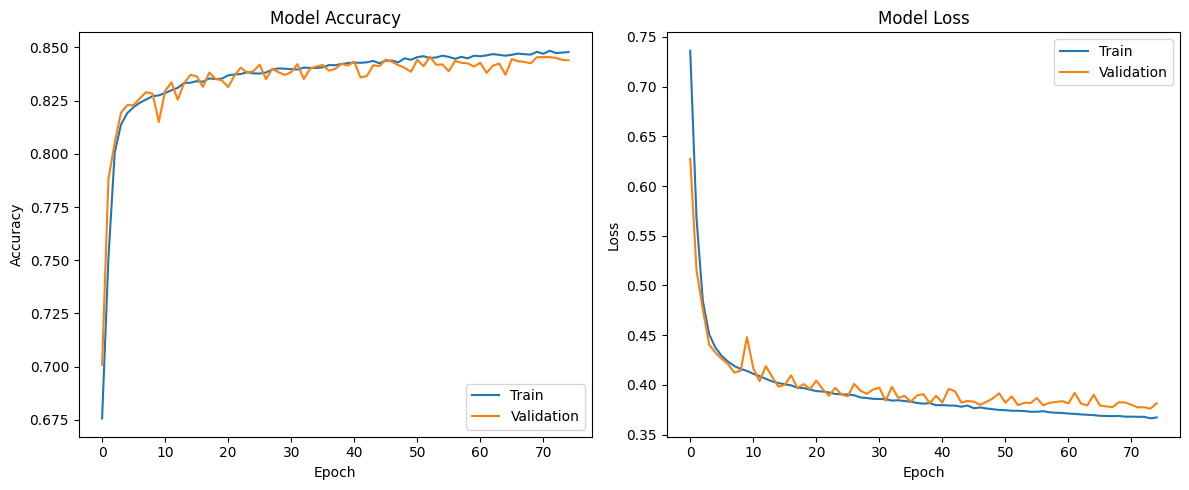

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [ ]:
# model using sequential API - 3 by 5
model = Sequential([
    Conv2D(32, (2, 2), activation='relu', input_shape=(3, 5, 1)),  # First conv layer
    Conv2D(64, (1, 1), activation='relu'),  # Second conv layer
    Flatten(),  # Flatten the tensor to feed it to dense layer
    Dense(128, activation='relu'),  # Fully connected layer
    Dense(6, activation='softmax')  # Output layer for 7 classes
])

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')
print(model.summary())

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.6302 - loss: 0.9136 - val_accuracy: 0.7783 - val_loss: 0.5563
Epoch 2/10
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7815 - loss: 0.5474 - val_accuracy: 0.8100 - val_loss: 0.4907
Epoch 3/10
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8056 - loss: 0.4981 - val_accuracy: 0.8182 - val_loss: 0.4661
Epoch 4/10
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8147 - loss: 0.4753 - val_accuracy: 0.8222 - val_loss: 0.4525
Epoch 5/10
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8219 - loss: 0.4609 - val_accuracy: 0.8189 - val_loss: 0.4603
Epoch 6/10
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8208 - loss: 0.4564 - val_accuracy: 0.8257 - val_loss: 0.4410
Epoch 7/10
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8225 - loss: 0.4514 - val_accuracy: 0.8253 - val_loss: 0.4397
Epoch 8/10
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8259 - loss: 0.4432 - val

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 2, 4, 32)            │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 2, 4, 64)            │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 206,132 (805.21 KB)

 Trainable params: 68,710 (268.40 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,422 (536.81 KB)

None


In [ ]:
# model using Functional API - 3 by 5

inputs = Input(shape=(3, 5, 1))
x = Conv2D(32, (2, 2), activation='relu')(inputs)  # First conv layer
x = Conv2D(64, (1, 1), activation='relu')(x)  # Second conv layer
x = Flatten()(x)  # Flatten the tensor to feed it to dense layer
x = Dense(128, activation='relu')(x)  # Fully connected layer
outputs = Dense(6, activation='softmax')(x)  # Output layer for 6 classes

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')
print(model.summary())

Epoch 1/10
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.6208 - loss: 0.9489 - val_accuracy: 0.7828 - val_loss: 0.5353
Epoch 2/10
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.7893 - loss: 0.5352 - val_accuracy: 0.8122 - val_loss: 0.4890
Epoch 3/10
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8073 - loss: 0.4939 - val_accuracy: 0.8210 - val_loss: 0.4710
Epoch 4/10
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8148 - loss: 0.4742 - val_accuracy: 0.8040 - val_loss: 0.4894
Epoch 5/10
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8173 - loss: 0.4625 - val_accuracy: 0.8249 - val_loss: 0.4463
Epoch 6/10
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8201 - loss: 0.4558 - val_accuracy: 0.8295 - val_loss: 0.4420
Epoch 7/10
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8223 - loss: 0.4503 - val_accuracy: 0.8251 - val_loss: 0.4414
Epoch 8/10
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8232 - loss: 0

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 3, 5, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 2, 4, 32)            │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 2, 4, 64)            │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 206,132 (805.21 KB)

 Trainable params: 68,710 (268.40 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,422 (536.81 KB)

None


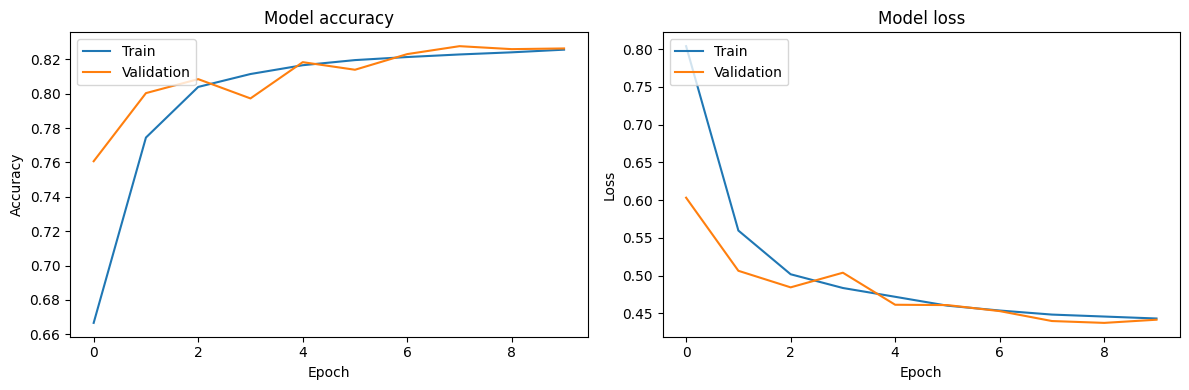

In [ ]:
import matplotlib.pyplot as plt

# Assume `history` is the History object returned by model.fit()

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Assuming you trained your model like this:
# history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
plot_training_history(history)


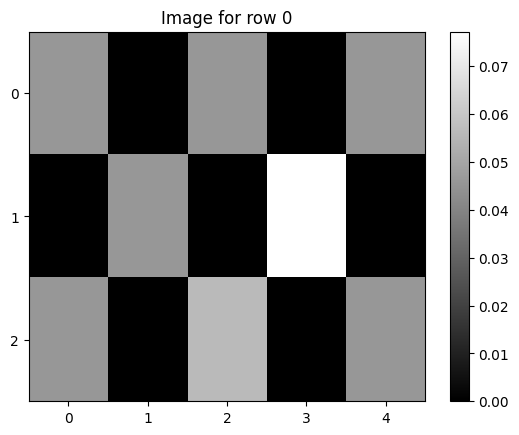

,Image,Label
0,"[[0.04561403508771929, 0.0, 0.0456140350877192...",good
1,"[[0.04561403508771929, 0.0, 0.0456140350877192...",good
2,"[[0.04561403508771929, 0.0, 0.0456140350877192...",good
3,"[[0.04561403508771929, 0.0, 0.0456140350877192...",good
4,"[[0.04912280701754385, 0.0, 0.0456140350877192...",good
...,...,...
155646,"[[0.017543859649122806, 0.0, 0.042105263157894...",bad_front
155647,"[[0.017543859649122806, 0.0, 0.045614035087719...",bad_front
155648,"[[0.01403508771929824, 0.0, 0.0456140350877192...",bad_front
155649,"[[0.017543859649122806, 0.0, 0.045614035087719...",bad_front


In [ ]:
plot_image_from_dataframe(first, 0)
first

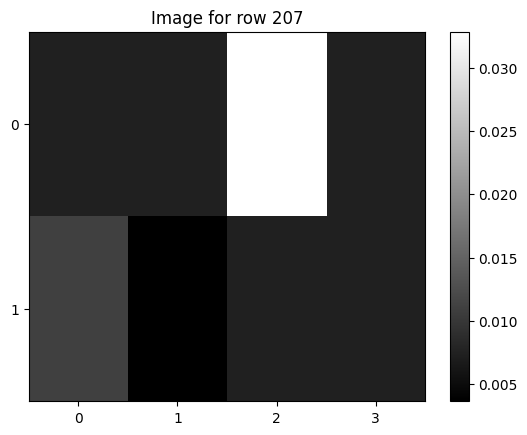

,Image,Label
0,"[[0.0036496350364963134, 0.0072992700729926675...",good
1,"[[0.01094890510948902, 0.0072992700729926675, ...",good
2,"[[0.0072992700729926675, 0.0072992700729926675...",good
3,"[[0.0072992700729926675, 0.0072992700729926675...",good
4,"[[0.0072992700729926675, 0.0072992700729926675...",good
...,...,...
1643,"[[0.025547445255474435, 0.02919708029197079, 0...",good
1644,"[[0.02919708029197079, 0.03284671532846715, 0....",good
1645,"[[0.02919708029197079, 0.02919708029197079, 0....",good
1646,"[[0.02919708029197079, 0.03284671532846715, 0....",good


In [ ]:
plot_image_from_dataframe(second, 207)
second

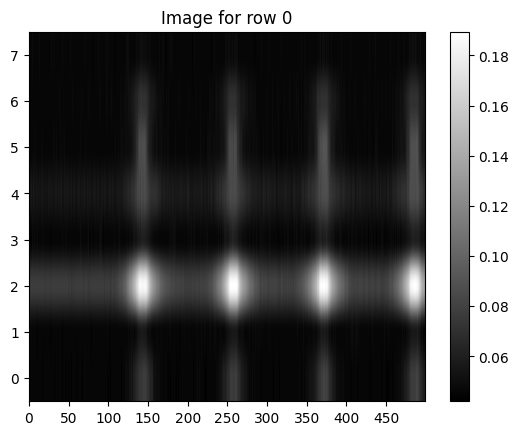

,Image,Label
0,"[[0.04561403508771929, 0.04561403508771929, 0....",good
1,"[[0.06666666666666668, 0.07017543859649124, 0....",good
2,"[[0.056140350877192984, 0.05263157894736842, 0...",good
3,"[[0.04561403508771929, 0.04561403508771929, 0....",good
4,"[[0.04561403508771929, 0.04561403508771929, 0....",good
...,...,...
580,"[[0.13333333333333333, 0.12982456140350876, 0....",bad_front
581,"[[0.08070175438596494, 0.07719298245614037, 0....",bad_front
582,"[[0.056140350877192984, 0.05263157894736842, 0...",bad_front
583,"[[0.04912280701754385, 0.04561403508771929, 0....",bad_front


In [ ]:
def plot_image_from_dataframe_for_time_series(images_df, index, xlabel=None, ylabel=None, xticks=None, yticks=None):
    # Extract the image from the DataFrame
    image = images_df.loc[index, 'Image']

    # Plot the image
    plt.figure()
    plt.imshow(image, cmap='gray', aspect='auto')
    plt.colorbar()
    plt.title(f"Image for row {index}")

    # Set axis labels if provided
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().invert_yaxis()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Set custom ticks if provided
    if xticks:
        plt.xticks(xticks)
    if yticks:
        plt.yticks(yticks)

    plt.show()

plot_image_from_dataframe_for_time_series(third, 0)
third